In [1]:
!pip install requests

In [2]:
!pip install boto3

In [3]:
import pandas as pd
import requests
import json
import boto3
from io import StringIO

In [4]:
API_KEY = "7500f5a30e6282ccf916cc2e413dce32"
BASE_URL = "https://v3.football.api-sports.io"

# HTTP header has to be "x-apisports-key" with the personal token as value.
HEADERS = {
    "x-apisports-key": API_KEY
}

# AWS S3 
S3_BUCKET_NAME = "premier-league-data-tal"
S3_FILE_NAME = "premier_league_matches.json"

In [5]:
def fetch_premier_league_matches(season=2024):
    url = f"{BASE_URL}/fixtures"
    params = {
        "league": 39,  # premier league ID in API-football
        "season": season
    }
    response = requests.get(url, headers=HEADERS, params=params)

    if response.status_code == 200:
        match_data = response.json()
        return match_data["response"]
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_multiple_seasons(start_year=2019, end_year=2024):
    all_matches = []

    for season in range(start_year, end_year + 1):
        print(f"Fetching data for season {season}...")
        url = f"{BASE_URL}/fixtures"
        params = {"league": 39, "season": season}  # premier league ID = 39

        response = requests.get(url, headers=HEADERS, params=params)

        if response.status_code == 200:
            matches = response.json()["response"]
            all_matches.extend(matches)  # append matches from this season
        else:
            print(f"Error fetching season {season}: {response.status_code}")

    return all_matches


# upload data to AWS S3
def upload_to_s3(data, bucket_name, file_name):
    s3 = boto3.client("s3")
    json_data = json.dumps(data, indent=4)

    try:
        s3.put_object(Bucket=bucket_name, Key=file_name, Body=json_data)
        print(f"File uploaded to S3: s3://{bucket_name}/{file_name}")
    except Exception as e:
        print(f"Error uploading to S3: {e}")

In [6]:
match_data = fetch_multiple_seasons(2019, 2024)
upload_to_s3(match_data, S3_BUCKET_NAME, S3_FILE_NAME)

Fetching data for season 2019...
Fetching data for season 2020...
Fetching data for season 2021...
Fetching data for season 2022...
Fetching data for season 2023...
Fetching data for season 2024...
File uploaded to S3: s3://premier-league-data-tal/premier_league_matches.json


In [7]:
print(match_data)

[{'fixture': {'id': 710556, 'referee': 'M. Oliver', 'timezone': 'UTC', 'date': '2021-08-13T19:00:00+00:00', 'timestamp': 1628881200, 'periods': {'first': 1628881200, 'second': 1628884800}, 'venue': {'id': 10503, 'name': 'Brentford Community Stadium', 'city': 'Brentford, Middlesex'}, 'status': {'long': 'Match Finished', 'short': 'FT', 'elapsed': 90, 'extra': None}}, 'league': {'id': 39, 'name': 'Premier League', 'country': 'England', 'logo': 'https://media.api-sports.io/football/leagues/39.png', 'flag': 'https://media.api-sports.io/flags/gb-eng.svg', 'season': 2021, 'round': 'Regular Season - 1', 'standings': True}, 'teams': {'home': {'id': 55, 'name': 'Brentford', 'logo': 'https://media.api-sports.io/football/teams/55.png', 'winner': True}, 'away': {'id': 42, 'name': 'Arsenal', 'logo': 'https://media.api-sports.io/football/teams/42.png', 'winner': False}}, 'goals': {'home': 2, 'away': 0}, 'score': {'halftime': {'home': 1, 'away': 0}, 'fulltime': {'home': 2, 'away': 0}, 'extratime': {'h

In [8]:
def load_data_from_s3(bucket_name, file_name):
    s3 = boto3.client("s3")

    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    data = json.loads(response["Body"].read().decode("utf-8"))

    return pd.DataFrame(data)  # convert JSON to dataframe

In [9]:
df = load_data_from_s3(S3_BUCKET_NAME, S3_FILE_NAME)

In [10]:
print(df.head(1))

                                             fixture  \
0  {'id': 710556, 'referee': 'M. Oliver', 'timezo...   

                                              league  \
0  {'id': 39, 'name': 'Premier League', 'country'...   

                                               teams                   goals  \
0  {'home': {'id': 55, 'name': 'Brentford', 'logo...  {'home': 2, 'away': 0}   

                                               score  
0  {'halftime': {'home': 1, 'away': 0}, 'fulltime...  


In [11]:
print(df.columns)

Index(['fixture', 'league', 'teams', 'goals', 'score'], dtype='object')


In [12]:
fixture_df = pd.json_normalize(df['fixture'])
league_df = pd.json_normalize(df['league'])
teams_df = pd.json_normalize(df['teams'])
goals_df = pd.json_normalize(df['goals'])
score_df = pd.json_normalize(df['score'])

flattened_df = pd.concat([fixture_df, league_df, teams_df, goals_df, score_df], axis=1)

In [13]:
print(flattened_df.head(2))

       id     referee timezone                       date   timestamp  \
0  710556   M. Oliver      UTC  2021-08-13T19:00:00+00:00  1628881200   
1  710561  P. Tierney      UTC  2021-08-14T11:30:00+00:00  1628940600   

   periods.first  periods.second  venue.id                   venue.name  \
0     1628881200      1628884800   10503.0  Brentford Community Stadium   
1     1628940600      1628944200     556.0                 Old Trafford   

             venue.city  ... home away  halftime.home halftime.away  \
0  Brentford, Middlesex  ...    2    0              1             0   
1            Manchester  ...    5    1              1             0   

   fulltime.home fulltime.away extratime.home extratime.away penalty.home  \
0              2             0           None           None         None   
1              5             1           None           None         None   

   penalty.away  
0          None  
1          None  

[2 rows x 40 columns]


In [14]:
print(flattened_df.columns)

Index(['id', 'referee', 'timezone', 'date', 'timestamp', 'periods.first',
       'periods.second', 'venue.id', 'venue.name', 'venue.city', 'status.long',
       'status.short', 'status.elapsed', 'status.extra', 'id', 'name',
       'country', 'logo', 'flag', 'season', 'round', 'standings', 'home.id',
       'home.name', 'home.logo', 'home.winner', 'away.id', 'away.name',
       'away.logo', 'away.winner', 'home', 'away', 'halftime.home',
       'halftime.away', 'fulltime.home', 'fulltime.away', 'extratime.home',
       'extratime.away', 'penalty.home', 'penalty.away'],
      dtype='object')


In [15]:
flattened_df = flattened_df.rename(columns={
    "id": "match_id",   
    "name": "league_name",
    "country": "league_country",
    "season": "league_season",
    "round": "match_round",
    "home.id": "home_team_id",
    "home.name": "home_team",
    "away.id": "away_team_id",
    "away.name": "away_team",
    "fulltime.home": "home_goals",
    "fulltime.away": "away_goals",
    "status.long": "match_status"
})

# drop irrelevant or duplicate columns
flattened_df = flattened_df.drop(columns=["logo", "flag", "standings", "status.extra"], errors="ignore")

In [16]:
print(flattened_df.head())

   match_id     referee timezone                       date   timestamp  \
0    710556   M. Oliver      UTC  2021-08-13T19:00:00+00:00  1628881200   
1    710561  P. Tierney      UTC  2021-08-14T11:30:00+00:00  1628940600   
2    710565     M. Dean      UTC  2021-08-14T14:00:00+00:00  1628949600   
3    710557    D. Coote      UTC  2021-08-14T14:00:00+00:00  1628949600   
4    710559   A. Madley      UTC  2021-08-14T14:00:00+00:00  1628949600   

   periods.first  periods.second  venue.id                   venue.name  \
0     1628881200      1628884800   10503.0  Brentford Community Stadium   
1     1628940600      1628944200     556.0                 Old Trafford   
2     1628949600      1628953200     596.0                Vicarage Road   
3     1628949600      1628953200     512.0                    Turf Moor   
4     1628949600      1628953200    8560.0                Goodison Park   

             venue.city  ... home away  halftime.home  halftime.away  \
0  Brentford, Middlesex  .

In [17]:
print(flattened_df.columns)

Index(['match_id', 'referee', 'timezone', 'date', 'timestamp', 'periods.first',
       'periods.second', 'venue.id', 'venue.name', 'venue.city',
       'match_status', 'status.short', 'status.elapsed', 'match_id',
       'league_name', 'league_country', 'league_season', 'match_round',
       'home_team_id', 'home_team', 'home.logo', 'home.winner', 'away_team_id',
       'away_team', 'away.logo', 'away.winner', 'home', 'away',
       'halftime.home', 'halftime.away', 'home_goals', 'away_goals',
       'extratime.home', 'extratime.away', 'penalty.home', 'penalty.away'],
      dtype='object')


In [18]:
columns_to_drop = [
    "match_id", "home.logo", "away.logo", "status.short", 
    "periods.first", "periods.second", "extratime.home", "extratime.away", 
    "penalty.home", "penalty.away", "home.winner", "away.winner", "venue.id"
]
flattened_df = flattened_df.drop(columns=columns_to_drop, errors="ignore")
print(flattened_df.columns)

Index(['referee', 'timezone', 'date', 'timestamp', 'venue.name', 'venue.city',
       'match_status', 'status.elapsed', 'league_name', 'league_country',
       'league_season', 'match_round', 'home_team_id', 'home_team',
       'away_team_id', 'away_team', 'home', 'away', 'halftime.home',
       'halftime.away', 'home_goals', 'away_goals'],
      dtype='object')


In [19]:
# dropped by accident both match_id and now i have to add 1 back
flattened_df["match_id"] = fixture_df["id"]
flattened_df = flattened_df[["match_id"] + [col for col in flattened_df.columns if col != "match_id"]]
print(flattened_df.columns)

Index(['match_id', 'referee', 'timezone', 'date', 'timestamp', 'venue.name',
       'venue.city', 'match_status', 'status.elapsed', 'league_name',
       'league_country', 'league_season', 'match_round', 'home_team_id',
       'home_team', 'away_team_id', 'away_team', 'home', 'away',
       'halftime.home', 'halftime.away', 'home_goals', 'away_goals'],
      dtype='object')


In [20]:
print(flattened_df.head(2))

   match_id     referee timezone                       date   timestamp  \
0    710556   M. Oliver      UTC  2021-08-13T19:00:00+00:00  1628881200   
1    710561  P. Tierney      UTC  2021-08-14T11:30:00+00:00  1628940600   

                    venue.name            venue.city    match_status  \
0  Brentford Community Stadium  Brentford, Middlesex  Match Finished   
1                 Old Trafford            Manchester  Match Finished   

   status.elapsed     league_name  ... home_team_id          home_team  \
0              90  Premier League  ...           55          Brentford   
1              90  Premier League  ...           33  Manchester United   

  away_team_id  away_team home  away halftime.home  halftime.away  home_goals  \
0           42    Arsenal    2     0             1              0           2   
1           63      Leeds    5     1             1              0           5   

   away_goals  
0           0  
1           1  

[2 rows x 23 columns]


In [21]:
flattened_df = flattened_df.rename(columns={
    "venue.name": "venue_name",
    "venue.city": "venue_city",
    "status.elapsed": "status_elapsed",
    "halftime.home": "halftime_home",
    "halftime.away": "halftime_away"
})
print(flattened_df.columns)

Index(['match_id', 'referee', 'timezone', 'date', 'timestamp', 'venue_name',
       'venue_city', 'match_status', 'status_elapsed', 'league_name',
       'league_country', 'league_season', 'match_round', 'home_team_id',
       'home_team', 'away_team_id', 'away_team', 'home', 'away',
       'halftime_home', 'halftime_away', 'home_goals', 'away_goals'],
      dtype='object')


In [22]:
# convert 'date' column to datetime
flattened_df["date"] = pd.to_datetime(flattened_df["date"])
flattened_df["timestamp"] = pd.to_datetime(flattened_df["timestamp"], unit="s")
print(flattened_df[["date", "timestamp"]].head())

                       date           timestamp
0 2021-08-13 19:00:00+00:00 2021-08-13 19:00:00
1 2021-08-14 11:30:00+00:00 2021-08-14 11:30:00
2 2021-08-14 14:00:00+00:00 2021-08-14 14:00:00
3 2021-08-14 14:00:00+00:00 2021-08-14 14:00:00
4 2021-08-14 14:00:00+00:00 2021-08-14 14:00:00


In [23]:
flattened_df.drop(columns=["timestamp"], inplace=True)
print(flattened_df.columns)

Index(['match_id', 'referee', 'timezone', 'date', 'venue_name', 'venue_city',
       'match_status', 'status_elapsed', 'league_name', 'league_country',
       'league_season', 'match_round', 'home_team_id', 'home_team',
       'away_team_id', 'away_team', 'home', 'away', 'halftime_home',
       'halftime_away', 'home_goals', 'away_goals'],
      dtype='object')


In [24]:
# save the dataframe as a CSV file
csv_filename = "premier_league_matches_cleaned.csv"
flattened_df.to_csv(csv_filename, index=False)

print(f"File saved: {csv_filename}")

File saved: premier_league_matches_cleaned.csv


In [25]:
# upload to AWS S3
s3 = boto3.client("s3")
s3_bucket = "premier-league-data-tal" 
s3_file_path = "cleaned_data/premier_league_matches_cleaned.csv"
s3.upload_file(csv_filename, s3_bucket, s3_file_path)

print(f"File uploaded to S3: s3://{s3_bucket}/{s3_file_path}")

File uploaded to S3: s3://premier-league-data-tal/cleaned_data/premier_league_matches_cleaned.csv


In [26]:
s3_bucket = "premier-league-data-tal"
s3_file_path = "cleaned_data/premier_league_matches_cleaned.csv"

s3 = boto3.client("s3")

response = s3.get_object(Bucket=s3_bucket, Key=s3_file_path)

df = pd.read_csv(StringIO(response["Body"].read().decode("utf-8")))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   match_id        1140 non-null   int64 
 1   referee         1140 non-null   object
 2   timezone        1140 non-null   object
 3   date            1140 non-null   object
 4   venue_name      1140 non-null   object
 5   venue_city      1140 non-null   object
 6   match_status    1140 non-null   object
 7   status_elapsed  1140 non-null   int64 
 8   league_name     1140 non-null   object
 9   league_country  1140 non-null   object
 10  league_season   1140 non-null   int64 
 11  match_round     1140 non-null   object
 12  home_team_id    1140 non-null   int64 
 13  home_team       1140 non-null   object
 14  away_team_id    1140 non-null   int64 
 15  away_team       1140 non-null   object
 16  home            1140 non-null   int64 
 17  away            1140 non-null   int64 
 18  halftime

In [27]:
df.head()

,match_id,referee,timezone,date,venue_name,venue_city,match_status,status_elapsed,league_name,league_country,...,home_team_id,home_team,away_team_id,away_team,home,away,halftime_home,halftime_away,home_goals,away_goals
0,710556,M. Oliver,UTC,2021-08-13 19:00:00+00:00,Brentford Community Stadium,"Brentford, Middlesex",Match Finished,90,Premier League,England,...,55,Brentford,42,Arsenal,2,0,1,0,2,0
1,710561,P. Tierney,UTC,2021-08-14 11:30:00+00:00,Old Trafford,Manchester,Match Finished,90,Premier League,England,...,33,Manchester United,63,Leeds,5,1,1,0,5,1
2,710565,M. Dean,UTC,2021-08-14 14:00:00+00:00,Vicarage Road,Watford,Match Finished,90,Premier League,England,...,38,Watford,66,Aston Villa,3,2,2,0,3,2
3,710557,D. Coote,UTC,2021-08-14 14:00:00+00:00,Turf Moor,Burnley,Match Finished,90,Premier League,England,...,44,Burnley,51,Brighton,1,2,1,0,1,2
4,710559,A. Madley,UTC,2021-08-14 14:00:00+00:00,Goodison Park,Liverpool,Match Finished,90,Premier League,England,...,45,Everton,41,Southampton,3,1,0,1,3,1


In [28]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])
print("\nSummary Statistics:\n", df.describe())
print("\nUnique values per column:\n", df.nunique())

Missing Values:
 Series([], dtype: int64)

Summary Statistics:
            match_id  status_elapsed  league_season  home_team_id  \
count  1.140000e+03          1140.0    1140.000000   1140.000000   
mean   8.714004e+05            90.0    2022.000000     69.050000   
std    1.325854e+05             0.0       0.816855    168.289802   
min    7.105560e+05            90.0    2021.000000     33.000000   
25%    7.108408e+05            90.0    2021.000000     40.000000   
50%    8.681355e+05            90.0    2022.000000     47.000000   
75%    1.035131e+06            90.0    2023.000000     52.000000   
max    1.035553e+06            90.0    2023.000000   1359.000000   

       away_team_id         home         away  halftime_home  halftime_away  \
count   1140.000000  1140.000000  1140.000000    1140.000000    1140.000000   
mean      69.050000     1.649123     1.334211       0.725439       0.592982   
std      168.289802     1.375073     1.244361       0.863392       0.793490   
min    

In [29]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

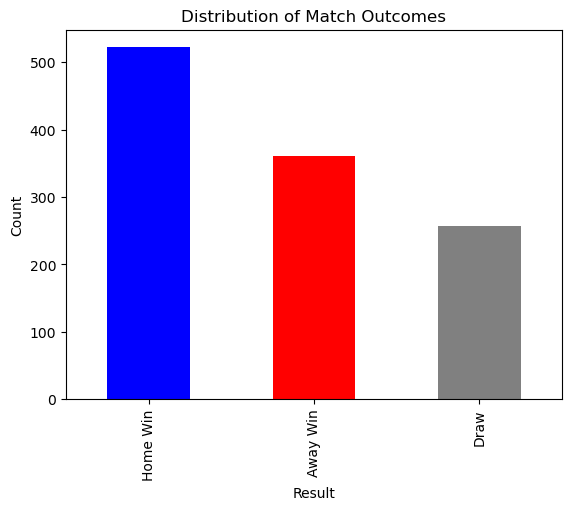

In [30]:
df["match_result"] = df.apply(lambda row: "Home Win" if row["home_goals"] > row["away_goals"] 
                              else "Away Win" if row["home_goals"] < row["away_goals"] 
                              else "Draw", axis=1)

df["match_result"].value_counts().plot(kind="bar", color=["blue", "red", "gray"])
plt.title("Distribution of Match Outcomes")
plt.xlabel("Result")
plt.ylabel("Count")
plt.show()

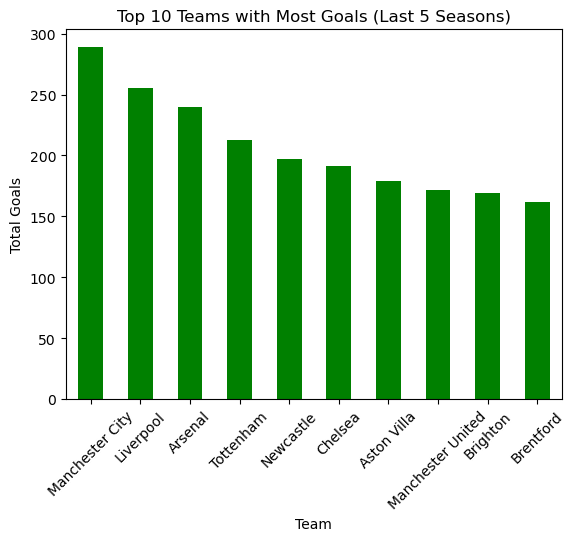

In [31]:
team_goals = df.groupby("home_team")["home_goals"].sum() + df.groupby("away_team")["away_goals"].sum()
team_goals = team_goals.sort_values(ascending=False).head(10)  

team_goals.plot(kind="bar", color="green")
plt.title("Top 10 Teams with Most Goals (Last 5 Seasons)")
plt.xlabel("Team")
plt.ylabel("Total Goals")
plt.xticks(rotation=45)
plt.show()

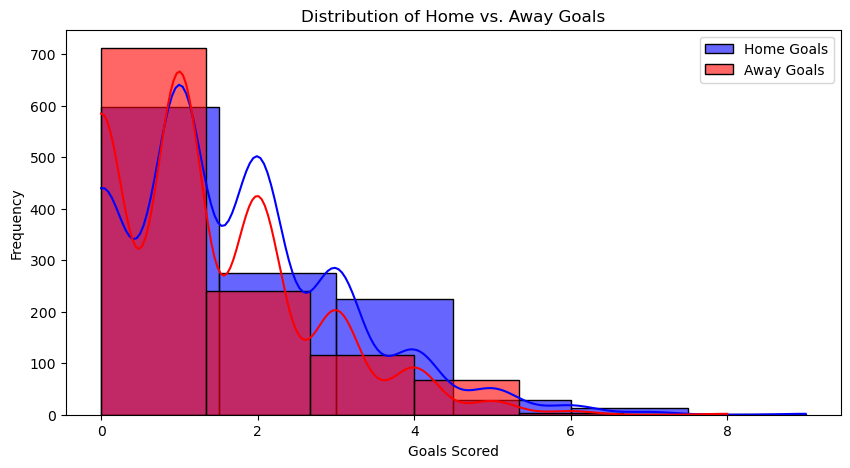

In [32]:
plt.figure(figsize=(10, 5))

sns.histplot(df["home_goals"], bins=6, kde=True, color="blue", label="Home Goals", alpha=0.6)

sns.histplot(df["away_goals"], bins=6, kde=True, color="red", label="Away Goals", alpha=0.6)

plt.title("Distribution of Home vs. Away Goals")
plt.xlabel("Goals Scored")
plt.ylabel("Frequency")
plt.legend()
plt.show()

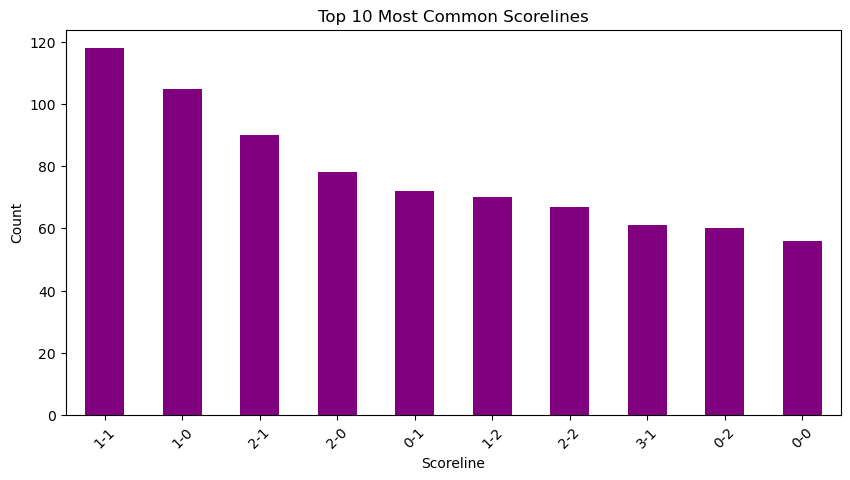

In [33]:
plt.figure(figsize=(10, 5))

df["scoreline"] = df["home_goals"].astype(str) + "-" + df["away_goals"].astype(str)
df["scoreline"].value_counts().head(10).plot(kind="bar", color="purple")

plt.title("Top 10 Most Common Scorelines")
plt.xlabel("Scoreline")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

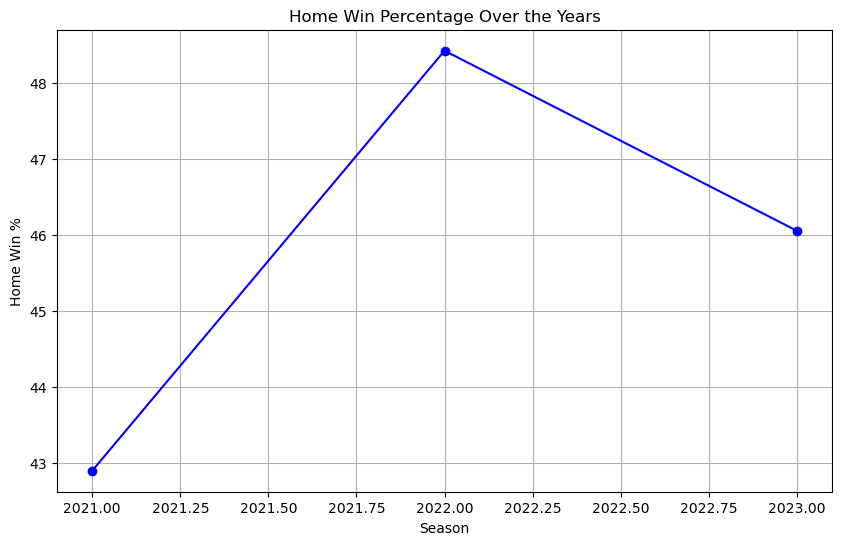

In [34]:
plt.figure(figsize=(10, 6))

home_wins = df[df["match_result"] == "Home Win"].groupby("league_season").size()
total_matches = df.groupby("league_season").size()
home_win_pct = (home_wins / total_matches) * 100

home_win_pct.plot(marker="o", color="blue")
plt.title("Home Win Percentage Over the Years")
plt.xlabel("Season")
plt.ylabel("Home Win %")
plt.grid()
plt.show()

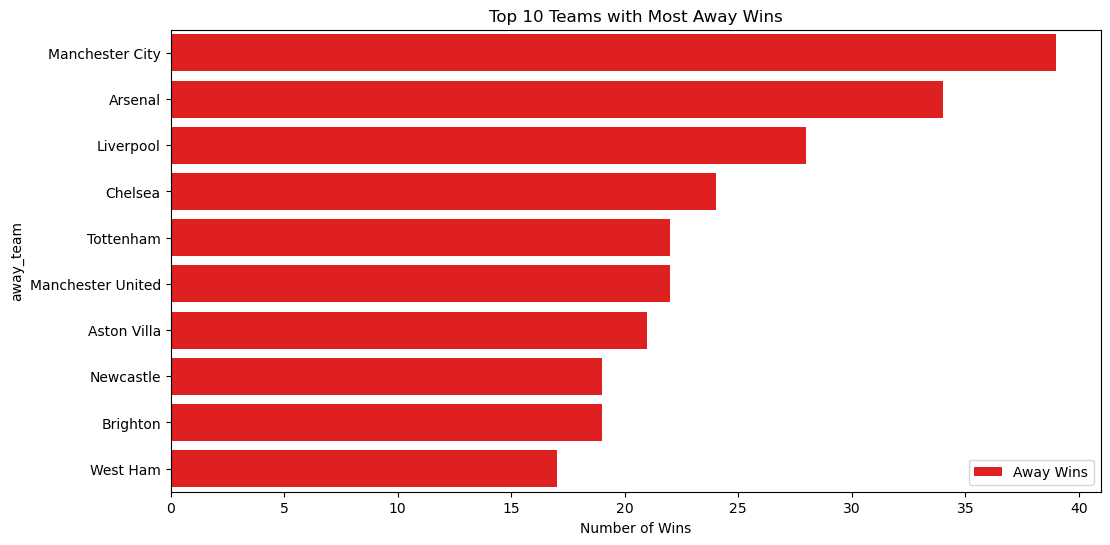

In [35]:
plt.figure(figsize=(12, 6))

away_wins = df[df["match_result"] == "Away Win"]["away_team"].value_counts().head(10)

sns.barplot(x=away_wins.values, y=away_wins.index, color="red", label="Away Wins")

plt.title("Top 10 Teams with Most Away Wins")
plt.xlabel("Number of Wins")
plt.legend()
plt.show()

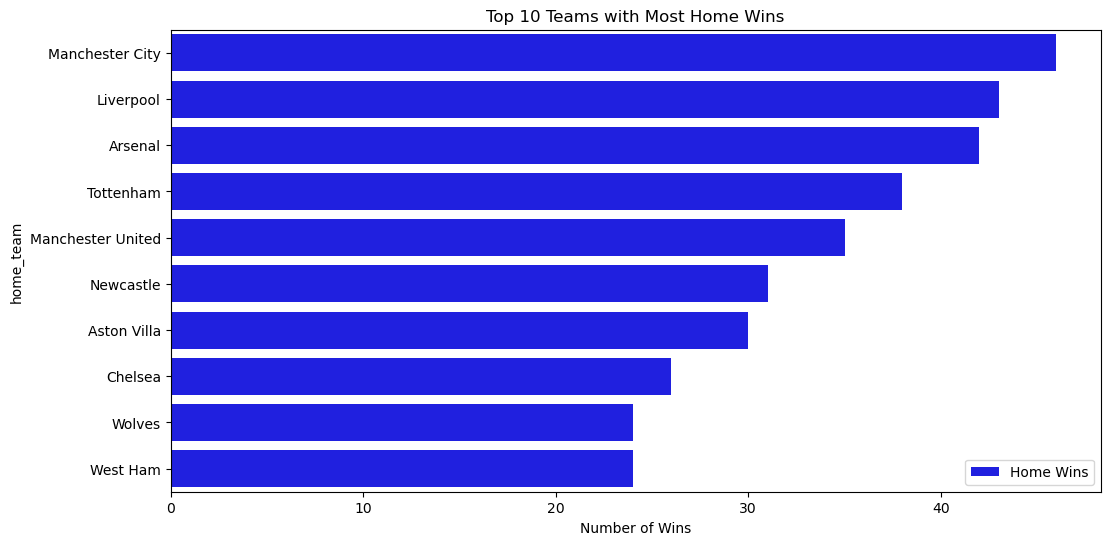

In [36]:
plt.figure(figsize=(12, 6))

home_wins = df[df["match_result"] == "Home Win"]["home_team"].value_counts().head(10)

sns.barplot(x=home_wins.values, y=home_wins.index, color="blue", label="Home Wins")

plt.title("Top 10 Teams with Most Home Wins")
plt.xlabel("Number of Wins")
plt.legend()
plt.show()

In [37]:
import boto3
import pandas as pd
from io import StringIO
import numpy as np

In [38]:
bucket_name = "premier-league-data-tal"
s3 = boto3.client('s3')
response = s3.list_objects_v2(Bucket=bucket_name)

if "Contents" in response:
    for obj in response["Contents"]:
        print(obj["Key"])  
else:
    print("No files found in the bucket.")


cleaned_data/premier_league_matches_cleaned.csv
match_data.csv
models/sagemaker-xgboost-2025-03-23-13-50-21-887/debug-output/training_job_end.ts
models/sagemaker-xgboost-2025-03-23-13-50-21-887/profiler-output/framework/training_job_end.ts
models/sagemaker-xgboost-2025-03-23-13-50-21-887/profiler-output/system/incremental/2025032313/1742737860.algo-1.json
models/sagemaker-xgboost-2025-03-23-13-50-21-887/profiler-output/system/incremental/2025032313/1742737920.algo-1.json
models/sagemaker-xgboost-2025-03-23-13-50-21-887/profiler-output/system/incremental/2025032313/1742737980.algo-1.json
models/sagemaker-xgboost-2025-03-23-13-50-21-887/profiler-output/system/training_job_end.ts
premier_league_matches.json


In [39]:
file_name = "cleaned_data/premier_league_matches_cleaned.csv"
obj = s3.get_object(Bucket=bucket_name, Key=file_name)
data = obj['Body'].read().decode('utf-8')

df = pd.read_csv(StringIO(data))

In [40]:
df.head()

,match_id,referee,timezone,date,venue_name,venue_city,match_status,status_elapsed,league_name,league_country,...,home_team_id,home_team,away_team_id,away_team,home,away,halftime_home,halftime_away,home_goals,away_goals
0,710556,M. Oliver,UTC,2021-08-13 19:00:00+00:00,Brentford Community Stadium,"Brentford, Middlesex",Match Finished,90,Premier League,England,...,55,Brentford,42,Arsenal,2,0,1,0,2,0
1,710561,P. Tierney,UTC,2021-08-14 11:30:00+00:00,Old Trafford,Manchester,Match Finished,90,Premier League,England,...,33,Manchester United,63,Leeds,5,1,1,0,5,1
2,710565,M. Dean,UTC,2021-08-14 14:00:00+00:00,Vicarage Road,Watford,Match Finished,90,Premier League,England,...,38,Watford,66,Aston Villa,3,2,2,0,3,2
3,710557,D. Coote,UTC,2021-08-14 14:00:00+00:00,Turf Moor,Burnley,Match Finished,90,Premier League,England,...,44,Burnley,51,Brighton,1,2,1,0,1,2
4,710559,A. Madley,UTC,2021-08-14 14:00:00+00:00,Goodison Park,Liverpool,Match Finished,90,Premier League,England,...,45,Everton,41,Southampton,3,1,0,1,3,1


In [41]:
# adding new res col to the df
def match_outcome(row):
    if row['home_goals'] > row['away_goals']:
        return 'home_win'
    elif row['home_goals'] < row['away_goals']:
        return 'away_win'
    else:
        return 'draw'

In [42]:
df['match_outcome'] = df.apply(match_outcome, axis=1)

In [43]:
# making a maving average for home and away goals for last 5 matches
df['home_team_5_game_avg_goals'] = df.groupby('home_team')['home_goals'].rolling(5, min_periods=1).mean().reset_index(0, drop=True)

df['away_team_5_game_avg_goals'] = df.groupby('away_team')['away_goals'].rolling(5, min_periods=1).mean().reset_index(0, drop=True)

In [44]:
df['home_team_advantage'] = df['home_team'] == df['home_team']

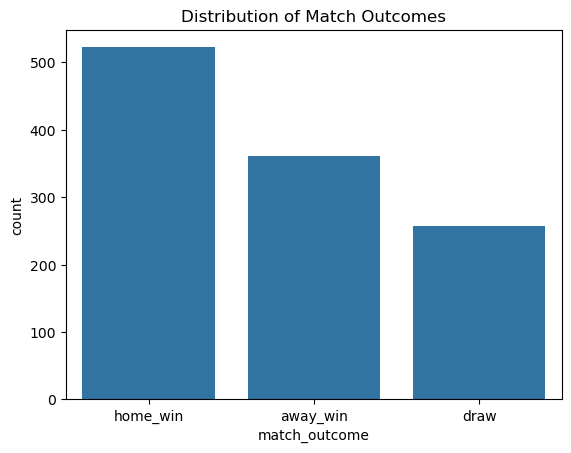

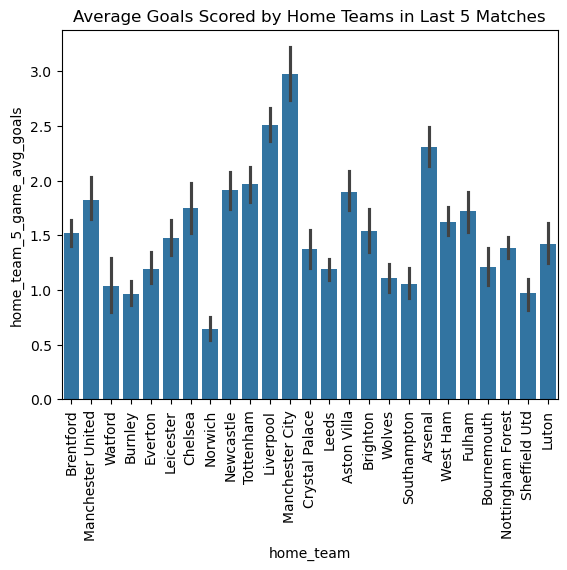

In [45]:
sns.countplot(data=df, x='match_outcome')
plt.title('Distribution of Match Outcomes')
plt.show()

sns.barplot(data=df, x='home_team', y='home_team_5_game_avg_goals')
plt.title('Average Goals Scored by Home Teams in Last 5 Matches')
plt.xticks(rotation=90)
plt.show()

In [46]:
df.columns

Index(['match_id', 'referee', 'timezone', 'date', 'venue_name', 'venue_city',
       'match_status', 'status_elapsed', 'league_name', 'league_country',
       'league_season', 'match_round', 'home_team_id', 'home_team',
       'away_team_id', 'away_team', 'home', 'away', 'halftime_home',
       'halftime_away', 'home_goals', 'away_goals', 'match_outcome',
       'home_team_5_game_avg_goals', 'away_team_5_game_avg_goals',
       'home_team_advantage'],
      dtype='object')

In [47]:
df['date'] = pd.to_datetime(df['date'])
df['match_outcome'] = df['match_outcome'].astype('category')

In [48]:
df = df.sort_values(by=['date'])

In [49]:
def compute_last_n_matches_stats(df, team_col, goals_col, n=5):
    df[team_col + '_last_' + str(n) + '_points'] = 0
    df[team_col + '_last_' + str(n) + '_goal_diff'] = 0

    for idx, row in df.iterrows():
        team_name = row[team_col]
        team_matches = df[df[team_col] == team_name].iloc[:n]

        points = team_matches[goals_col].apply(lambda x: 3 if x > 0 else (1 if x == 0 else 0)).sum()
        goal_diff = team_matches[goals_col].sum() - team_matches[goals_col].sum()

        df.at[idx, team_col + '_last_' + str(n) + '_points'] = points
        df.at[idx, team_col + '_last_' + str(n) + '_goal_diff'] = goal_diff

    return df

In [50]:
df.dtypes

match_id                                    int64
referee                                    object
timezone                                   object
date                          datetime64[ns, UTC]
venue_name                                 object
venue_city                                 object
match_status                               object
status_elapsed                              int64
league_name                                object
league_country                             object
league_season                               int64
match_round                                object
home_team_id                                int64
home_team                                  object
away_team_id                                int64
away_team                                  object
home                                        int64
away                                        int64
halftime_home                               int64
halftime_away                               int64


In [51]:
df = compute_last_n_matches_stats(df, 'home_team', 'home_goals')
df = compute_last_n_matches_stats(df, 'away_team', 'away_goals')

In [52]:
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].astype(str)  # has to convert othervise i get error
df.fillna(0, inplace=True)

In [53]:
df[['home_team_last_5_points', 'home_team_5_game_avg_goals', 'home_team_last_5_goal_diff',
    'away_team_last_5_points', 'away_team_5_game_avg_goals', 'away_team_last_5_goal_diff']].head()

,home_team_last_5_points,home_team_5_game_avg_goals,home_team_last_5_goal_diff,away_team_last_5_points,away_team_5_game_avg_goals,away_team_last_5_goal_diff
0,11,2.0,0,9,0.0,0
1,11,5.0,0,13,1.0,0
2,9,3.0,0,13,2.0,0
3,11,1.0,0,13,2.0,0
4,13,3.0,0,13,1.0,0


In [54]:
print(df.columns.tolist())

['match_id', 'referee', 'timezone', 'date', 'venue_name', 'venue_city', 'match_status', 'status_elapsed', 'league_name', 'league_country', 'league_season', 'match_round', 'home_team_id', 'home_team', 'away_team_id', 'away_team', 'home', 'away', 'halftime_home', 'halftime_away', 'home_goals', 'away_goals', 'match_outcome', 'home_team_5_game_avg_goals', 'away_team_5_game_avg_goals', 'home_team_advantage', 'home_team_last_5_points', 'home_team_last_5_goal_diff', 'away_team_last_5_points', 'away_team_last_5_goal_diff']


In [55]:
home_matches = df[df['home_team'] == df['home_team']]
away_matches = df[df['away_team'] == df['away_team']]

In [56]:
home_wins = home_matches[home_matches['match_outcome'] == 'home_win']
home_win_rate = home_wins.groupby('home_team').size() / home_matches.groupby('home_team').size()

In [57]:
away_wins = away_matches[away_matches['match_outcome'] == 'away_win']
away_win_rate = away_wins.groupby('away_team').size() / away_matches.groupby('away_team').size()

In [58]:
win_rate_df = pd.DataFrame({
    'team': home_win_rate.index,
    'home_win_rate': home_win_rate.values,
    'away_win_rate': away_win_rate.values
})

In [59]:
df = pd.merge(df, win_rate_df[['team', 'home_win_rate']], how='left', left_on='home_team', right_on='team')
df = pd.merge(df, win_rate_df[['team', 'away_win_rate']], how='left', left_on='away_team', right_on='team', suffixes=('_home', '_away'))

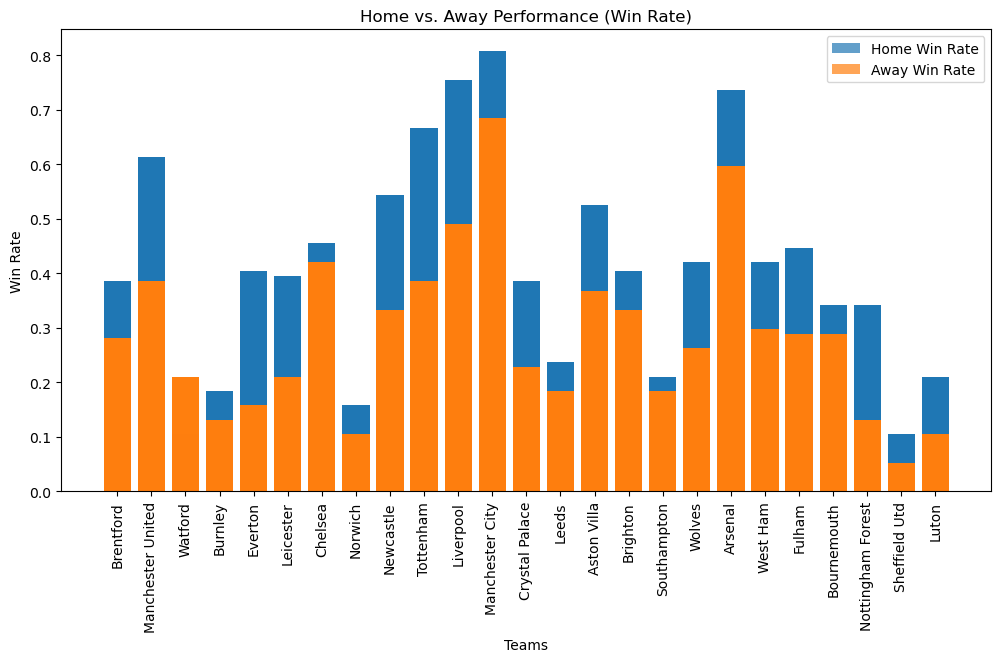

In [60]:
plt.figure(figsize=(12, 6))

# Home win rate plot
plt.bar(df['home_team'], df['home_win_rate'], label='Home Win Rate', alpha=0.7)

# Away win rate plot
plt.bar(df['away_team'], df['away_win_rate'], label='Away Win Rate', alpha=0.7)

plt.title('Home vs. Away Performance (Win Rate)')
plt.xlabel('Teams')
plt.ylabel('Win Rate')
plt.xticks(rotation=90)
plt.legend()

plt.show()

In [61]:
df['win_rate_advantage'] = df['home_win_rate'] - df['away_win_rate']

# building the match prediction

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [63]:
df['match_outcome_encoded'] = df['match_outcome'].map({'home_win': 1, 'away_win': 0, 'draw': 2})

In [64]:
features = [
    'home_team_5_game_avg_goals',
    'away_team_5_game_avg_goals',
    'home_win_rate',
    'away_win_rate',
    'home_team_advantage',
    'home_team_5_game_avg_goals',
    'away_team_5_game_avg_goals'
]

X = df[features]
y = df['match_outcome_encoded']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [68]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6359649122807017
              precision    recall  f1-score   support

           0       0.59      0.68      0.63        74
           1       0.66      0.86      0.75       110
           2       0.00      0.00      0.00        44

    accuracy                           0.64       228
   macro avg       0.42      0.51      0.46       228
weighted avg       0.51      0.64      0.57       228



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Using AWS SageMaker for machine learning model

In [69]:
s3 = boto3.client('s3')
bucket_name = 'premier-league-data-tal'
file_name = 'match_data.csv'

In [70]:
df.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket_name, file_name)

In [71]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn import SKLearnModel
from sagemaker.sklearn.estimator import SKLearnModel

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [85]:
from sagemaker.xgboost import XGBoostModel
from sagemaker.xgboost.estimator import XGBoost

In [73]:
role = get_execution_role()
s3_train_path = f's3://{bucket_name}/{file_name}'

xgb_estimator = sagemaker.estimator.Estimator(
    image_uri=sagemaker.image_uris.retrieve("xgboost", region="eu-north-1", version="1.5-1"),
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket_name}/models/",
    sagemaker_session=sagemaker.Session()
)

[03/24/25 10:44:17] INFO     Ignoring unnecessary instance type: None.                            ]8;id=831304;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=903416;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [74]:
xgb_estimator.set_hyperparameters(
    max_depth=5,
    eta=0.1,
    objective="binary:logistic",
    eval_metric="logloss",
    num_round=100
)

In [75]:
xgb_estimator.fit({'train': s3_train_path})

[03/24/25 10:44:18] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=454182;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=707923;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[03/24/25 10:44:19] INFO     Creating training-job with name:                                       ]8;id=84692;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=289581;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-24-10-44-18-993                                             

2025-03-24 10:44:21 Starting - Starting the training job...
..25-03-24 10:44:36 Starting - Preparing the instances for training.
..25-03-24 10:44:57 Downloading - Downloading input data.
.....03-24 10:45:42 Downloading - Downloading the training image.
2025-03-24 10:46:54 Training - Training image download completed. Training in progress.
2025-03-24 10:46:54 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-03-24 10:46:43.248 ip-10-0-251-6.eu-north-1.compute.internal:6 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-03-24 10:46:43.274 ip-10-0-251-6.eu-north-1.compute.internal:6 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-03-24:10:46:43:INFO] Imported framework sagemaker_xgboost_container.trai

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit({'train': s3_train_path})                                                  │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [76]:
xgb_predictor = xgb_estimator.deploy(
    instance_type="ml.m5.large",
    initial_instance_count=1
)

[03/24/25 10:56:28] INFO     Creating model with name: sagemaker-xgboost-2025-03-24-10-56-28-335    ]8;id=3083;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=289798;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_predictor = xgb_estimator.deploy(                                                        │
│   2 │   instance_type="ml.m5.large",                                                             │
│   3 │   initial_instance_count=1                                                                 │
│   4 )                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1722 in deploy                    │
│                                                                                                  │
│   1719 │   │   │   inference_tags=format_tags(tags), training_tags=self.tags                     │
│   1720 │   │   )                                                                                 │
│   1721 │   │                                                                                     │
│ ❱ 1722 │   │   return model.deploy(                                                              │
│   1723 │   │   │   instance_type=instance_type,                                                  │
│   1724 │   │   │   initial_instance_count=initial_instance_count,                                │
│   1725 │   │   │   serializer=serializer,                                                        │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/model.py:1728 in deploy                        │
│                                                                                                  │
│   1725 │   │   │   return None                                                                   │
│   1726 │   │                                                                                     │
│   1727 │   │   else:  # existing single model endpoint path                                      │
│ ❱ 1728 │   │   │   self._create_sagemaker_model(                                                 │
│   1729 │   │   │   │   instance_type=instance_type,                                              │
│   1730 │   │   │   │   accelerator_type=accelerator_type,                                        │
│   1731 │   │   │   │   tags=tags,                                                                │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/model.py:985 in _create_sagemaker_model        │
│                                                                                                  │
│    982 │   │   │   │   enable_network_isolation=self._enable_network_isolation,                  │
│    983 │   │   │   │   tags=format_tags(tags),                                                   │
│    984 │   │   │   )                                                                             │
│ ❱  985 │   │   │   self.sagemaker_session.create_model(**create_model_args)                      │
│    986 │                                                                                         │
│    987 │   def _get_model_uri(self):                                                             │
│    988 │   │   model_uri = None                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/session.py:4109 in create_model                │
│                                                            

In [77]:
print(xgb_estimator.latest_training_job.describe()['ModelArtifacts']['S3ModelArtifacts'])

s3://premier-league-data-tal/models/sagemaker-xgboost-2025-03-24-10-44-18-993/output/model.tar.gz


In [78]:
print(xgb_estimator.latest_training_job.describe()['TrainingJobStatus'])

Failed


In [79]:
print(xgb_estimator.latest_training_job.describe()['FailureReason'])

AlgorithmError: framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_containers/_trainer.py", line 84, in train
    entrypoint()
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/training.py", line 102, in main
    train(framework.training_env())
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/training.py", line 98, in train
    run_algorithm_mode()
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/training.py", line 64, in run_algorithm_mode
    sagemaker_train(
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/algorithm_mode/train.py", line 198, in sagemaker_train
    train_dmatrix, val_dmatrix, train_val_dmatrix = get_validated_dmatrices(
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/algorithm_mode/train.py", line 78, in get_validated_dmatrices
    validate_data_file_path(train_path, content_

In [80]:
print(train_data_s3_path)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 print(train_data_s3_path)                                                                    │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'train_data_s3_path' is not defined

In [81]:
print(xgb_estimator.hyperparameters())
print(xgb_estimator.input_mode)
print(xgb_estimator.latest_training_job.describe()['InputDataConfig'])

{'max_depth': 5, 'eta': 0.1, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'num_round': 100}
File
[{'ChannelName': 'train', 'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://premier-league-data-tal/match_data.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'CompressionType': 'None', 'RecordWrapperType': 'None'}]


In [82]:
s3_data_path = "s3://premier-league-data-tal/match_data.csv" 
df = pd.read_csv(s3_data_path)
print(df.head())

   match_id     referee timezone                       date  \
0    710556   M. Oliver      UTC  2021-08-13 19:00:00+00:00   
1    710561  P. Tierney      UTC  2021-08-14 11:30:00+00:00   
2    710565     M. Dean      UTC  2021-08-14 14:00:00+00:00   
3    710557    D. Coote      UTC  2021-08-14 14:00:00+00:00   
4    710559   A. Madley      UTC  2021-08-14 14:00:00+00:00   

                    venue_name            venue_city    match_status  \
0  Brentford Community Stadium  Brentford, Middlesex  Match Finished   
1                 Old Trafford            Manchester  Match Finished   
2                Vicarage Road               Watford  Match Finished   
3                    Turf Moor               Burnley  Match Finished   
4                Goodison Park             Liverpool  Match Finished   

   status_elapsed     league_name league_country  ...  \
0              90  Premier League        England  ...   
1              90  Premier League        England  ...   
2              90

In [83]:
train_data_s3_path = "s3://premier-league-data-tal/match_data.csv"

In [89]:
role = get_execution_role()

In [97]:
xgb_estimator = XGBoostModel(
    entry_point='train.py',
    role=role,
    hyperparameters={"max-depth": 6, "learning-rate": 0.1, "n-estimators": 100},
    source_dir='s3://premier-league-data-tal/scripts/',
    model_data="s3://premier-league-data-tal/models/",
    sagemaker_session=sagemaker.Session()
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator = XGBoostModel(                                                                │
│   2 │   entry_point='train.py',                                                                  │
│   3 │   role=role,                                                                               │
│   4 │   hyperparameters={"max-depth": 6, "learning-rate": 0.1, "n-estimators": 100},             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/xgboost/model.py:132 in __init__               │
│                                                                                                  │
│   129 │   │   │   :class:`~sagemaker.model.FrameworkModel` and                                   │
│   130 │   │   │   :class:`~sagemaker.model.Model`.                                               │
│   131 │   │   """                                                                                │
│ ❱ 132 │   │   super(XGBoostModel, self).__init__(                                                │
│   133 │   │   │   model_data, image_uri, role, entry_point, predictor_cls=predictor_cls, **kwa   │
│   134 │   │   )                                                                                  │
│   135                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/model.py:2123 in __init__                      │
│                                                                                                  │
│   2120 │   │   │   You can find additional parameters for initializing this class at             │
│   2121 │   │   │   :class:`~sagemaker.model.Model`.                                              │
│   2122 │   │   """                                                                               │
│ ❱ 2123 │   │   super(FrameworkModel, self).__init__(                                             │
│   2124 │   │   │   image_uri,                                                                    │
│   2125 │   │   │   model_data,                                                                   │
│   2126 │   │   │   role,                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: Model.__init__() got an unexpected keyword argument 'hyperparameters'

In [98]:
xgb_estimator = XGBoost(
    entry_point='train.py',
    role=role,
    source_dir='s3://premier-league-data-tal/scripts/',
    sagemaker_session=sagemaker.Session(),
    hyperparameters={
        "max_depth": 6,
        "learning_rate": 0.1,
        "n_estimators": 100,
    },
    framework_version='1.0-1',
    instance_type="ml.m5.large",
    instance_count=1
)

In [100]:
xgb_estimator.fit("s3://premier-league-data-tal/match_data.tar.gz")

[03/24/25 13:55:10] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=531969;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=145683;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=42381;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=229851;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-24-13-55-10-541                                             

2025-03-24 13:55:10 Starting - Starting the training job......
.....03-24 13:56:07 Downloading - Downloading input data.
..25-03-24 13:56:47 Downloading - Downloading the training image.
[2025-03-24 13:57:42.694 ip-10-0-133-165.eu-north-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
ERROR:sagemaker-containers:Reporting training FAILURE
ERROR:sagemaker-containers:framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/tarfile.py", line 2289, in next
    tarinfo = self.tarinfo.fromtarfile(self)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1095, in fromtarfile
    obj = cls.frombuf(buf, tarfile.encoding, tarfile.errors)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1031, in frombuf
    raise Em

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit("s3://premier-league-data-tal/match_data.tar.gz")                          │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [101]:
df = pd.read_csv("s3://premier-league-data-tal/match_data.csv")

In [102]:
print(df.dtypes)

match_id                        int64
referee                        object
timezone                       object
date                           object
venue_name                     object
venue_city                     object
match_status                   object
status_elapsed                  int64
league_name                    object
league_country                 object
league_season                   int64
match_round                    object
home_team_id                    int64
home_team                      object
away_team_id                    int64
away_team                      object
home                            int64
away                            int64
halftime_home                   int64
halftime_away                   int64
home_goals                      int64
away_goals                      int64
match_outcome                  object
home_team_5_game_avg_goals    float64
away_team_5_game_avg_goals    float64
home_team_advantage              bool
home_team_la

In [103]:
categorical_cols = ["referee", "timezone", "venue_name", "venue_city", "league_name", "league_country",
                    "match_round", "home_team", "away_team", "team_home", "team_away"]

for col in categorical_cols:
    df[col] = df[col].astype("category").cat.codes

In [104]:
print(df.dtypes)

match_id                        int64
referee                          int8
timezone                         int8
date                           object
venue_name                       int8
venue_city                       int8
match_status                   object
status_elapsed                  int64
league_name                      int8
league_country                   int8
league_season                   int64
match_round                      int8
home_team_id                    int64
home_team                        int8
away_team_id                    int64
away_team                        int8
home                            int64
away                            int64
halftime_home                   int64
halftime_away                   int64
home_goals                      int64
away_goals                      int64
match_outcome                  object
home_team_5_game_avg_goals    float64
away_team_5_game_avg_goals    float64
home_team_advantage              bool
home_team_la

In [105]:
df["home_team_advantage"] = df["home_team_advantage"].astype(int)

In [106]:
df = df.drop(columns=["date"])

In [107]:
df = df.drop(columns=["match_outcome"])

In [109]:
df = df.drop(columns=["match_status"])

In [110]:
print(df.dtypes)

match_id                        int64
referee                          int8
timezone                         int8
venue_name                       int8
venue_city                       int8
status_elapsed                  int64
league_name                      int8
league_country                   int8
league_season                   int64
match_round                      int8
home_team_id                    int64
home_team                        int8
away_team_id                    int64
away_team                        int8
home                            int64
away                            int64
halftime_home                   int64
halftime_away                   int64
home_goals                      int64
away_goals                      int64
home_team_5_game_avg_goals    float64
away_team_5_game_avg_goals    float64
home_team_advantage             int64
home_team_last_5_points         int64
home_team_last_5_goal_diff      int64
away_team_last_5_points         int64
away_team_la

In [111]:
df.to_csv("s3://premier-league-data-tal/cleaned_match_data.csv", index=False)

In [112]:
xgb_estimator.fit("s3://premier-league-data-tal/cleaned_match_data.csv")

[03/25/25 10:30:39] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=396365;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=178189;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=306915;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=174089;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-25-10-30-39-775                                             

2025-03-25 10:30:41 Starting - Starting the training job...
.....03-25 10:31:15 Downloading - Downloading input data.
....[2025-03-25 10:32:50.846 ip-10-0-165-144.eu-north-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
ERROR:sagemaker-containers:Reporting training FAILURE
ERROR:sagemaker-containers:framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/tarfile.py", line 2289, in next
    tarinfo = self.tarinfo.fromtarfile(self)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1095, in fromtarfile
    obj = cls.frombuf(buf, tarfile.encoding, tarfile.errors)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1031, in frombuf
    raise EmptyHeaderError("empty header")
tarfile.EmptyHeaderError: empty he

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit("s3://premier-league-data-tal/cleaned_match_data.csv")                     │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [113]:
df = pd.read_csv("s3://premier-league-data-tal/cleaned_match_data.csv")

In [114]:
print(df.dtypes)

match_id                        int64
referee                         int64
timezone                        int64
venue_name                      int64
venue_city                      int64
status_elapsed                  int64
league_name                     int64
league_country                  int64
league_season                   int64
match_round                     int64
home_team_id                    int64
home_team                       int64
away_team_id                    int64
away_team                       int64
home                            int64
away                            int64
halftime_home                   int64
halftime_away                   int64
home_goals                      int64
away_goals                      int64
home_team_5_game_avg_goals    float64
away_team_5_game_avg_goals    float64
home_team_advantage             int64
home_team_last_5_points         int64
home_team_last_5_goal_diff      int64
away_team_last_5_points         int64
away_team_la

In [115]:
df = df.rename(columns={'match_outcome_encoded': 'match_outcome'})

In [116]:
print(df.dtypes)

match_id                        int64
referee                         int64
timezone                        int64
venue_name                      int64
venue_city                      int64
status_elapsed                  int64
league_name                     int64
league_country                  int64
league_season                   int64
match_round                     int64
home_team_id                    int64
home_team                       int64
away_team_id                    int64
away_team                       int64
home                            int64
away                            int64
halftime_home                   int64
halftime_away                   int64
home_goals                      int64
away_goals                      int64
home_team_5_game_avg_goals    float64
away_team_5_game_avg_goals    float64
home_team_advantage             int64
home_team_last_5_points         int64
home_team_last_5_goal_diff      int64
away_team_last_5_points         int64
away_team_la

In [117]:
df.to_csv("s3://premier-league-data-tal/cleaned_match_data.csv", index=False)

In [118]:
xgb_estimator.fit("s3://premier-league-data-tal/cleaned_match_data.csv")

[03/25/25 10:48:16] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=398747;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=165315;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=170341;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=5295;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-25-10-48-16-278                                             

2025-03-25 10:48:17 Starting - Starting the training job...
..25-03-25 10:48:32 Starting - Preparing the instances for training.
..25-03-25 10:48:53 Downloading - Downloading input data.
....[2025-03-25 10:50:29.328 ip-10-0-99-235.eu-north-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
ERROR:sagemaker-containers:Reporting training FAILURE
ERROR:sagemaker-containers:framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/tarfile.py", line 2289, in next
    tarinfo = self.tarinfo.fromtarfile(self)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1095, in fromtarfile
    obj = cls.frombuf(buf, tarfile.encoding, tarfile.errors)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1031, in frombuf
    raise

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit("s3://premier-league-data-tal/cleaned_match_data.csv")                     │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [119]:
xgb_estimator.fit("s3://premier-league-data-tal/cleaned_match_data.tar.gz")

[03/25/25 11:02:32] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=258132;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=328361;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=58313;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=212210;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-25-11-02-32-408                                             

2025-03-25 11:02:32 Starting - Starting the training job......
.....03-25 11:03:32 Downloading - Downloading input data.
..25-03-25 11:04:17 Downloading - Downloading the training image.
.[2025-03-25 11:05:12.888 ip-10-0-103-67.eu-north-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
ERROR:sagemaker-containers:Reporting training FAILURE
ERROR:sagemaker-containers:framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/tarfile.py", line 2289, in next
    tarinfo = self.tarinfo.fromtarfile(self)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1095, in fromtarfile
    obj = cls.frombuf(buf, tarfile.encoding, tarfile.errors)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1031, in frombuf
    raise Em

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit("s3://premier-league-data-tal/cleaned_match_data.tar.gz")                  │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [121]:
xgb_estimator.fit("s3://premier-league-data-tal/cleaned_match_data.tar.gz")

[03/25/25 11:21:50] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=496957;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=178735;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=415456;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=978703;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-25-11-21-50-544                                             

2025-03-25 11:21:55 Starting - Starting the training job...
..25-03-25 11:22:11 Starting - Preparing the instances for training.
..25-03-25 11:22:31 Downloading - Downloading input data.
....[2025-03-25 11:24:07.020 ip-10-0-211-212.eu-north-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
ERROR:sagemaker-containers:Reporting training FAILURE
ERROR:sagemaker-containers:framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/tarfile.py", line 2289, in next
    tarinfo = self.tarinfo.fromtarfile(self)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1095, in fromtarfile
    obj = cls.frombuf(buf, tarfile.encoding, tarfile.errors)
  File "/miniconda3/lib/python3.7/tarfile.py", line 1031, in frombuf
    rais

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit("s3://premier-league-data-tal/cleaned_match_data.tar.gz")                  │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [124]:
xgb_estimator = XGBoost(
    entry_point="train.py",
    role=role,
    source_dir='s3://premier-league-data-tal/scripts/',
    framework_version="1.5-1",
    instance_count=1,
    instance_type="ml.m5.large"
)

[03/25/25 11:39:14] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=954156;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=123016;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=177579;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=542775;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [125]:
xgb_estimator.fit("s3://premier-league-data-tal/match_data.tar.gz")

[03/25/25 11:39:17] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=415367;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=412385;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=986251;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=831614;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-25-11-39-17-498                                             

2025-03-25 11:39:19 Starting - Starting the training job...
.....03-25 11:39:53 Downloading - Downloading input data.
.....03-25 11:40:33 Downloading - Downloading the training image.
2025-03-25 11:41:54 Training - Training image download completed. Training in progress.
2025-03-25 11:41:54 Uploading - Uploading generated training model
2025-03-25 11:41:54 Failed - Training job failed
/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-03-25 11:41:34.742 ip-10-0-153-110.eu-north-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-03-25 11:41:34.766 ip-10-0-153-110.eu-north-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-03-25:11:41:35:INFO] Imported framework sagemaker_xgboost_container.training
[2025-03-2

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit("s3://premier-league-data-tal/match_data.tar.gz")                          │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [128]:
xgb_estimator = XGBoost(
    entry_point='train.py',
    source_dir='s3://premier-league-data-tal/scripts/',
    role=role,
    framework_version='1.5-1',
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://premier-league-data-tal/models/'
)

[03/25/25 13:16:27] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=487160;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=316907;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.large.                     ]8;id=149002;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=751011;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [129]:
xgb_estimator.fit({'train': 's3://premier-league-data-tal/cleaned_match_data.tar.gz'})

[03/25/25 13:16:29] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=320434;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=997740;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=446465;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=489712;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-25-13-16-29-548                                             

2025-03-25 13:16:30 Starting - Starting the training job...
..25-03-25 13:16:45 Starting - Preparing the instances for training.
..25-03-25 13:17:05 Downloading - Downloading input data.
.....03-25 13:17:50 Downloading - Downloading the training image.
2025-03-25 13:18:57 Training - Training image download completed. Training in progress.
2025-03-25 13:18:57 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-03-25 13:18:51.828 ip-10-0-78-72.eu-north-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-03-25 13:18:51.851 ip-10-0-78-72.eu-north-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-03-25:13:18:52:INFO] Imported framework sagemaker_xgboost_container.trai

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit({'train': 's3://premier-league-data-tal/cleaned_match_data.tar.gz'})       │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [150]:
import pandas as pd
import sagemaker
from sagemaker import LinearLearner
import io
import boto3
import sagemaker.amazon.common as smac

In [156]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
s3_bucket = "premier-league-data-tal"
s3_prefix = "linear-learner"
train_data_s3_path = f"s3://{s3_bucket}/{s3_prefix}/train.csv"

In [157]:
df.to_csv("train.csv", index=False, header=False)
sagemaker_session.upload_data("train.csv", bucket=s3_bucket, key_prefix=s3_prefix)

's3://premier-league-data-tal/linear-learner/train.csv'

In [158]:
print("Data uploaded to:", train_data_s3_path)

Data uploaded to: s3://premier-league-data-tal/linear-learner/train.csv


In [159]:
linear_estimator = LinearLearner(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    predictor_type="multiclass_classifier",
    num_classes=3,
    sagemaker_session=sagemaker_session
)

In [160]:
linear_estimator.fit({"train": train_data_s3_path})

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 linear_estimator.fit({"train": train_data_s3_path})                                          │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/amazon/amazon_estimator.py:263 in fit          │
│                                                                                                  │
│   260 │   │   │   │   will be unassociated.                                                      │
│   261 │   │   │   │   * `TrialComponentDisplayName` is used for display in Studio.               │
│   262 │   │   """                                                                                │
│ ❱ 263 │   │   self._prepare_for_training(records, job_name=job_name, mini_batch_size=mini_batc   │
│   264 │   │                                                                                      │
│   265 │   │   experiment_config = check_and_get_run_experiment_config(experiment_config)         │
│   266 │   │   self.latest_training_job = _TrainingJob.start_new(                                 │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/amazon/linear_learner.py:438 in                │
│ _prepare_for_training                                                                            │
│                                                                                                  │
│   435 │   │   │   if num_records is None:                                                        │
│   436 │   │   │   │   raise ValueError("Must provide train channel.")                            │
│   437 │   │   else:                                                                              │
│ ❱ 438 │   │   │   num_records = records.num_records                                              │
│   439 │   │                                                                                      │
│   440 │   │   # mini_batch_size can't be greater than number of records or training job fails    │
│   441 │   │   mini_batch_size = mini_batch_size or self._get_default_mini_batch_size(num_recor   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'dict' object has no attribute 'num_records'

In [161]:
from sagemaker.inputs import TrainingInput

In [162]:
train_data_input = TrainingInput(
    s3_data=train_data_s3_path,
    content_type="csv"
)

In [163]:
linear_estimator.fit({"train": train_data_input})

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 linear_estimator.fit({"train": train_data_input})                                            │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/amazon/amazon_estimator.py:263 in fit          │
│                                                                                                  │
│   260 │   │   │   │   will be unassociated.                                                      │
│   261 │   │   │   │   * `TrialComponentDisplayName` is used for display in Studio.               │
│   262 │   │   """                                                                                │
│ ❱ 263 │   │   self._prepare_for_training(records, job_name=job_name, mini_batch_size=mini_batc   │
│   264 │   │                                                                                      │
│   265 │   │   experiment_config = check_and_get_run_experiment_config(experiment_config)         │
│   266 │   │   self.latest_training_job = _TrainingJob.start_new(                                 │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/amazon/linear_learner.py:438 in                │
│ _prepare_for_training                                                                            │
│                                                                                                  │
│   435 │   │   │   if num_records is None:                                                        │
│   436 │   │   │   │   raise ValueError("Must provide train channel.")                            │
│   437 │   │   else:                                                                              │
│ ❱ 438 │   │   │   num_records = records.num_records                                              │
│   439 │   │                                                                                      │
│   440 │   │   # mini_batch_size can't be greater than number of records or training job fails    │
│   441 │   │   mini_batch_size = mini_batch_size or self._get_default_mini_batch_size(num_recor   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'dict' object has no attribute 'num_records'

In [164]:
!aws s3 ls s3://premier-league-data-tal/

                           PRE cleaned_data/
                           PRE linear-learner/
                           PRE models/
                           PRE scripts/
2025-03-25 10:47:12     158644 cleaned_match_data.csv
2025-03-25 11:20:34      27931 cleaned_match_data.tar.gz
2025-03-24 10:44:13     339472 match_data.csv
2025-03-24 13:53:57      37552 match_data.tar.gz
2025-03-24 10:42:32    2243074 premier_league_matches.json


In [165]:
print(df.columns)

Index(['match_id', 'referee', 'timezone', 'venue_name', 'venue_city',
       'status_elapsed', 'league_name', 'league_country', 'league_season',
       'match_round', 'home_team_id', 'home_team', 'away_team_id', 'away_team',
       'home', 'away', 'halftime_home', 'halftime_away', 'home_goals',
       'away_goals', 'home_team_5_game_avg_goals',
       'away_team_5_game_avg_goals', 'home_team_advantage',
       'home_team_last_5_points', 'home_team_last_5_goal_diff',
       'away_team_last_5_points', 'away_team_last_5_goal_diff', 'team_home',
       'home_win_rate', 'team_away', 'away_win_rate', 'win_rate_advantage',
       'match_outcome'],
      dtype='object')


In [166]:
!pip install xgboost

In [167]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [169]:
df = pd.read_csv("match_data.csv")

In [170]:
df.head()

,match_id,referee,timezone,date,venue_name,venue_city,match_status,status_elapsed,league_name,league_country,...,home_team_last_5_points,home_team_last_5_goal_diff,away_team_last_5_points,away_team_last_5_goal_diff,team_home,home_win_rate,team_away,away_win_rate,win_rate_advantage,match_outcome_encoded
0,710556,M. Oliver,UTC,2021-08-13 19:00:00+00:00,Brentford Community Stadium,"Brentford, Middlesex",Match Finished,90,Premier League,England,...,11,0,9,0,Brentford,0.385965,Arsenal,0.596491,-0.210526,1
1,710561,P. Tierney,UTC,2021-08-14 11:30:00+00:00,Old Trafford,Manchester,Match Finished,90,Premier League,England,...,11,0,13,0,Manchester United,0.614035,Leeds,0.184211,0.429825,1
2,710565,M. Dean,UTC,2021-08-14 14:00:00+00:00,Vicarage Road,Watford,Match Finished,90,Premier League,England,...,9,0,13,0,Watford,0.105263,Aston Villa,0.368421,-0.263158,1
3,710557,D. Coote,UTC,2021-08-14 14:00:00+00:00,Turf Moor,Burnley,Match Finished,90,Premier League,England,...,11,0,13,0,Burnley,0.184211,Brighton,0.333333,-0.149123,0
4,710559,A. Madley,UTC,2021-08-14 14:00:00+00:00,Goodison Park,Liverpool,Match Finished,90,Premier League,England,...,13,0,13,0,Everton,0.403509,Southampton,0.184211,0.219298,1


In [196]:
df = pd.read_csv("cleaned_match_data.csv")

In [197]:
print(df.columns)

Index(['match_id', 'referee', 'timezone', 'venue_name', 'venue_city',
       'status_elapsed', 'league_name', 'league_country', 'league_season',
       'match_round', 'home_team_id', 'home_team', 'away_team_id', 'away_team',
       'home', 'away', 'halftime_home', 'halftime_away', 'home_goals',
       'away_goals', 'home_team_5_game_avg_goals',
       'away_team_5_game_avg_goals', 'home_team_advantage',
       'home_team_last_5_points', 'home_team_last_5_goal_diff',
       'away_team_last_5_points', 'away_team_last_5_goal_diff', 'team_home',
       'home_win_rate', 'team_away', 'away_win_rate', 'win_rate_advantage',
       'match_outcome'],
      dtype='object')


In [198]:
df.head()

,match_id,referee,timezone,venue_name,venue_city,status_elapsed,league_name,league_country,league_season,match_round,...,home_team_last_5_points,home_team_last_5_goal_diff,away_team_last_5_points,away_team_last_5_goal_diff,team_home,home_win_rate,team_away,away_win_rate,win_rate_advantage,match_outcome
0,710556,18,0,3,2,90,0,0,2021,0,...,11,0,9,0,3,0.385965,0,0.596491,-0.210526,1
1,710561,21,0,15,10,90,0,0,2021,0,...,11,0,13,0,15,0.614035,10,0.184211,0.429825,1
2,710565,16,0,24,16,90,0,0,2021,0,...,9,0,13,0,22,0.105263,1,0.368421,-0.263158,1
3,710557,6,0,23,3,90,0,0,2021,0,...,11,0,13,0,5,0.184211,4,0.333333,-0.149123,0
4,710559,0,0,9,7,90,0,0,2021,0,...,13,0,13,0,8,0.403509,20,0.184211,0.219298,1


In [199]:
cols_to_drop = [
    "match_id", "referee", "timezone", "venue_name", "venue_city",
    "home", "away", "halftime_home", "halftime_away", "home_goals", "away_goals",
    "home_team_id", "away_team_id", "team_home", "team_away", "status_elapsed",
    "league_name", "league_country", "league_season", "match_round"
]
df_cleaned = df.drop(columns=cols_to_drop)
X = df_cleaned.drop(columns=["match_outcome"])
y = df["match_outcome"]

In [200]:
print(X.head())

   home_team  away_team  home_team_5_game_avg_goals  \
0          3          0                         2.0   
1         15         10                         5.0   
2         22          1                         3.0   
3          5          4                         1.0   
4          8         20                         3.0   

   away_team_5_game_avg_goals  home_team_advantage  home_team_last_5_points  \
0                         0.0                    1                       11   
1                         1.0                    1                       11   
2                         2.0                    1                        9   
3                         2.0                    1                       11   
4                         1.0                    1                       13   

   home_team_last_5_goal_diff  away_team_last_5_points  \
0                           0                        9   
1                           0                       13   
2                   

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [202]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [203]:
params = {
    "objective": "multi:softmax",
    "num_class": len(y.unique()),
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3,
    "seed": 42
}

In [204]:
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [205]:
y_pred = model.predict(dtest)

In [206]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.58


In [207]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5789473684210527
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        76
           1       0.68      0.73      0.71       104
           2       0.25      0.19      0.21        48

    accuracy                           0.58       228
   macro avg       0.50      0.51      0.51       228
weighted avg       0.56      0.58      0.57       228



In [208]:
model.save_model("xgboost_model.json")

In [209]:
train_data_s3_path = "s3://premier-league-data-tal/cleaned_match_data.csv"
df_cleaned.to_csv("cleaned_match_data.csv", index=False)

In [210]:
s3 = boto3.client("s3")
bucket_name = "premier-league-data-tal"
s3.upload_file("cleaned_match_data.csv", bucket_name, "cleaned_match_data.csv")

In [211]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [212]:
train_s3_uri = f"s3://{bucket_name}/cleaned_match_data.csv"

In [214]:
from sagemaker.estimator import Estimator

In [219]:
xgb_estimator = Estimator(
    image_uri=sagemaker.image_uris.retrieve("xgboost", region="eu-north-1", version="1.5-1"),
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket_name}/model_output",
    sagemaker_session=sagemaker_session
)

[03/26/25 14:21:42] INFO     Ignoring unnecessary instance type: None.                            ]8;id=544971;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=23718;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [220]:
xgb_estimator.set_hyperparameters(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    num_round=100
)

In [221]:
xgb_estimator.fit({"train": train_s3_uri})

[03/26/25 14:21:46] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=860331;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=637228;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=311742;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=305413;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-26-14-21-46-049                                             

2025-03-26 14:21:46 Starting - Starting the training job...
..25-03-26 14:22:06 Starting - Preparing the instances for training.
..25-03-26 14:22:27 Downloading - Downloading input data.
.....03-26 14:23:13 Downloading - Downloading the training image.
2025-03-26 14:24:19 Training - Training image download completed. Training in progress.
2025-03-26 14:24:19 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-03-26 14:24:13.895 ip-10-0-237-26.eu-north-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-03-26 14:24:13.917 ip-10-0-237-26.eu-north-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-03-26:14:24:14:INFO] Imported framework sagemaker_xgboost_container.tr

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit({"train": train_s3_uri})                                                   │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [222]:
df_cleaned.to_csv("cleaned_match_data.csv", index=False, header=False)
s3.upload_file("cleaned_match_data.csv", bucket_name, "cleaned_match_data.csv")

In [223]:
xgb_estimator.set_hyperparameters(
    objective="multi:softmax",
    num_class=3,  
    eval_metric="mlogloss",
    num_round=100,
    tree_method="auto",
    predictor="cpu_predictor",
    verbosity=2
)

In [225]:
from sagemaker.inputs import TrainingInput

In [226]:
train_input = TrainingInput(s3_data=train_s3_uri, content_type="text/csv")

In [227]:
xgb_estimator.fit({"train": train_input})

[03/26/25 14:33:42] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=727261;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=962537;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=334985;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=825148;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-26-14-33-42-507                                             

2025-03-26 14:33:42 Starting - Starting the training job...
..25-03-26 14:34:03 Starting - Preparing the instances for training.
..25-03-26 14:34:22 Downloading - Downloading input data.
.....03-26 14:35:07 Downloading - Downloading the training image.
2025-03-26 14:36:14 Training - Training image download completed. Training in progress.
2025-03-26 14:36:14 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-03-26 14:36:08.514 ip-10-0-133-172.eu-north-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-03-26 14:36:08.541 ip-10-0-133-172.eu-north-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-03-26:14:36:08:INFO] Imported framework sagemaker_xgboost_container.

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 xgb_estimator.fit({"train": train_input})                                                    │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                                                                  │
│   1377 │   │   │   wait = True                                                                   │
│   1378 │   │   │   forward_to_mlflow_tracking_server = True

In [228]:
num_classes = df_cleaned["match_outcome"].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [230]:
df_cleaned["match_outcome"].unique()

array([1, 0, 2])